In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

import holidays

In [2]:
data_dir = Path('./data')

# Utility Functions
List of utility function to reformat dataframes or add features.

In [3]:
def add_index(df):
    # Convert the 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

    # Combine 'Date' and 'Hour' into a single datetime column
    df['Datetime'] = df['Date'] + pd.to_timedelta(df['Hour'] - 1, unit='h')

    # Set the new datetime column as the index
    df.set_index('Datetime', inplace=True)    
    return df

In [4]:
def score(prediction, actual):
    return np.sum((prediction - actual) ** 2)

In [5]:
def expanding_window_cross_validation(df, initial_train_years=1, years_in_data=3, first_year=2005):
    folds = []
    for year in range(initial_train_years, years_in_data):
        # Training set ends at the last hour of December 31st of the current year
        train_end_date = pd.Timestamp(f'{first_year + year}-12-31 23:00:00')
        
        # Testing set starts at the first hour of January 1st of the next year
        test_start_date = pd.Timestamp(f'{first_year + year + 1}-01-01 00:00:00')
        test_end_date = pd.Timestamp(f'{first_year + year + 1}-12-31 23:00:00')
        
        # Define the training and testing period
        train = df.loc[:train_end_date].copy()
        test = df.loc[test_start_date:test_end_date].copy()
        
        folds.append((train, test))
    
    return folds

# Data Loading & Processing

## Load

In [6]:
load = pd.read_csv(
    data_dir / "load_hist_data.csv"
)

In [7]:
load = add_index(load)

In [8]:
load.head()

,Date,Hour,Load
Datetime,,,
2005-01-01 00:00:00,2005-01-01,1,857
2005-01-01 01:00:00,2005-01-01,2,825
2005-01-01 02:00:00,2005-01-01,3,800
2005-01-01 03:00:00,2005-01-01,4,794
2005-01-01 04:00:00,2005-01-01,5,802


In [9]:
load.tail()

,Date,Hour,Load
Datetime,,,
2007-12-31 19:00:00,2007-12-31,20,1269
2007-12-31 20:00:00,2007-12-31,21,1255
2007-12-31 21:00:00,2007-12-31,22,1237
2007-12-31 22:00:00,2007-12-31,23,1212
2007-12-31 23:00:00,2007-12-31,24,1174


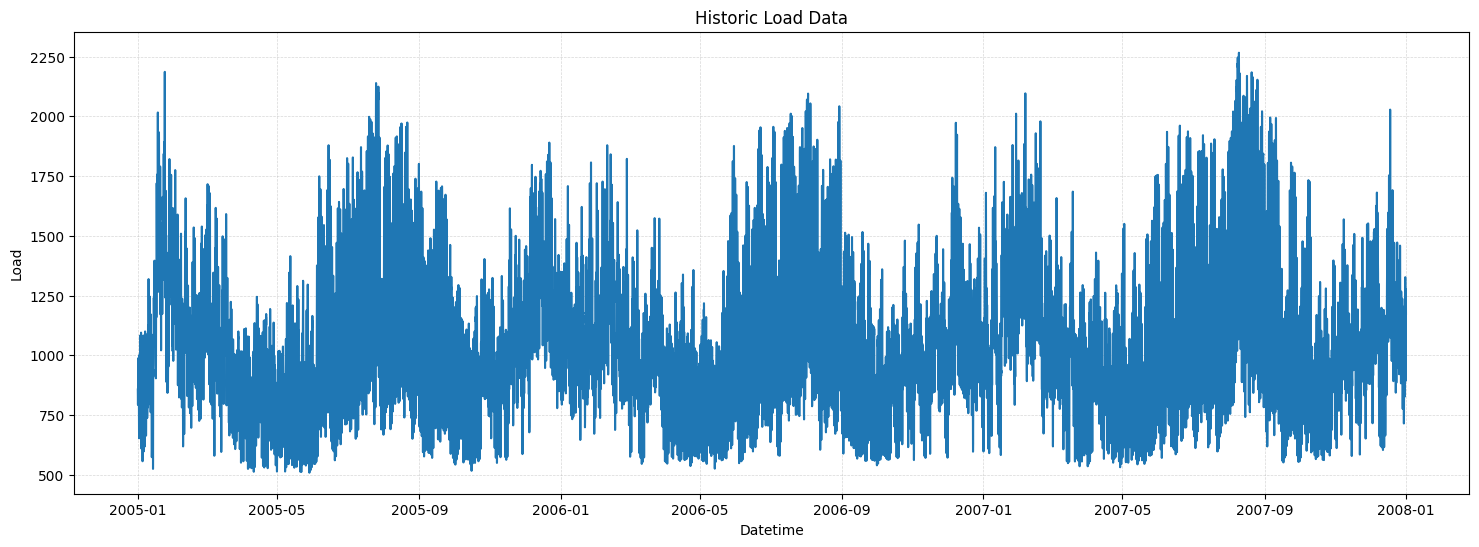

In [10]:
fig, ax = plt.subplots(figsize=(18, 6))

sns.lineplot(data=load, x=load.index, y='Load', ax=ax)

ax.set_title('Historic Load Data')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

In [11]:
print(f"Nans: {load['Load'].isna().sum()}")

Nans: 0


In [12]:
load_full_range = pd.date_range(start=load.index.min(), end=load.index.max(), freq="h")
load_missing_datetimes = load_full_range.difference(load.index)
print(f"Missing datetimes: {load_missing_datetimes}")
# Daylight Saving Time (DST) transition

Missing datetimes: DatetimeIndex(['2005-04-03 01:00:00', '2006-04-02 01:00:00',
               '2007-03-11 01:00:00'],
              dtype='datetime64[ns]', freq=None)


In [13]:
load_duplicated_datetimes = load.index[load.index.duplicated()]
print(f"Duplicated datetimes: {load_duplicated_datetimes}")
# Daylight Saving Time (DST) transition

Duplicated datetimes: DatetimeIndex(['2005-10-30 01:00:00', '2006-10-29 01:00:00',
               '2007-11-04 01:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)


In [14]:
load.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,26280,2006-07-02 00:36:03.287671168,2005-01-01 00:00:00,2005-10-01 00:00:00,2006-07-02 00:00:00,2007-04-02 00:00:00,2007-12-31 00:00:00,NaN
Hour,26280.0,12.5,1.0,6.75,12.5,18.25,24.0,6.922318
Load,26280.0,1071.858866,509.0,854.0,1009.0,1252.0,2266.0,313.951126


### Add peak feature

In [15]:
# Add peak load flag
load["is_peak"] = load.groupby("Date")["Load"].transform(lambda x: x == x.max()).astype(int)

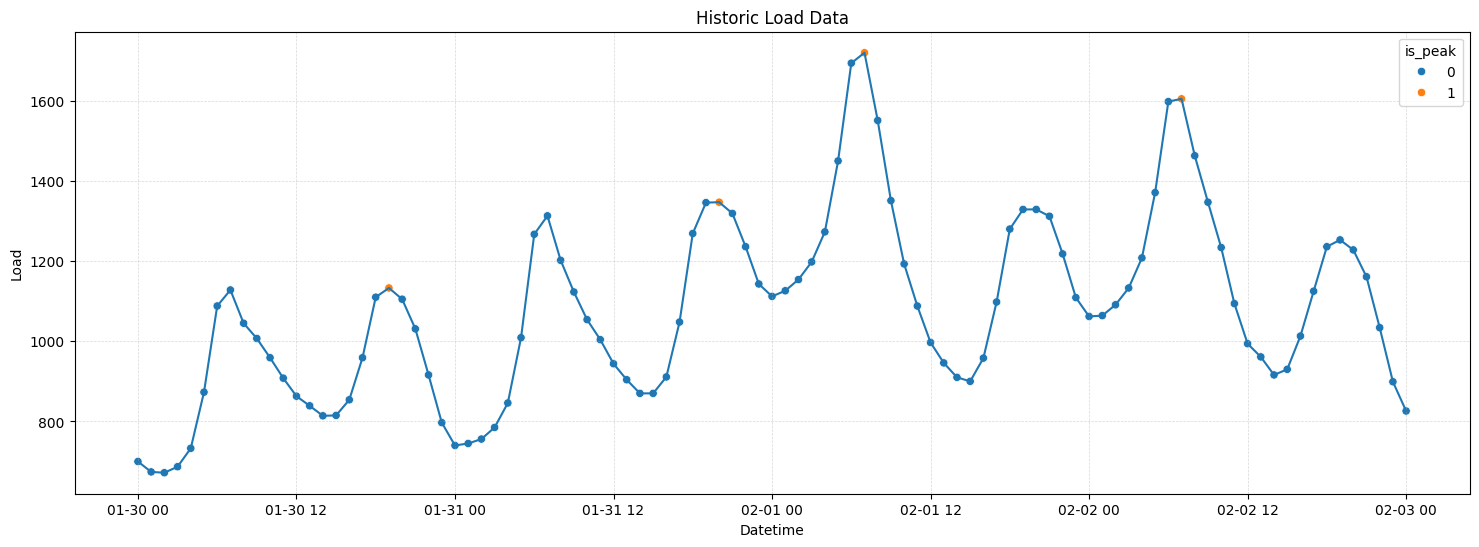

In [16]:
fig, ax = plt.subplots(figsize=(18, 6))

central_date = pd.to_datetime("2006-02-01")
delta = pd.Timedelta("2D")

sns.lineplot(
    data=load[central_date - delta : central_date + delta],
    x=load[central_date - delta : central_date + delta].index,
    y="Load",
    ax=ax,
)
sns.scatterplot(
    data=load[central_date - delta : central_date + delta],
    x=load[central_date - delta : central_date + delta].index,
    y="Load",
    hue="is_peak",
    ax=ax,
)

ax.set_title("Historic Load Data")
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

## Weather

In [17]:
weather = pd.read_csv(data_dir / 'weather_data.csv')

In [18]:
weather = add_index(weather)

In [19]:
weather_pivot = (
    add_index(weather)
    .reset_index()
    .pivot_table(index="Datetime", columns="Station ID", values="Temperature")
)
# Small approximation: duplicated values are replaced with the mean of the duplicates ()

In [20]:
weather_pivot.columns = [f"Station {col}" for col in weather_pivot.columns]

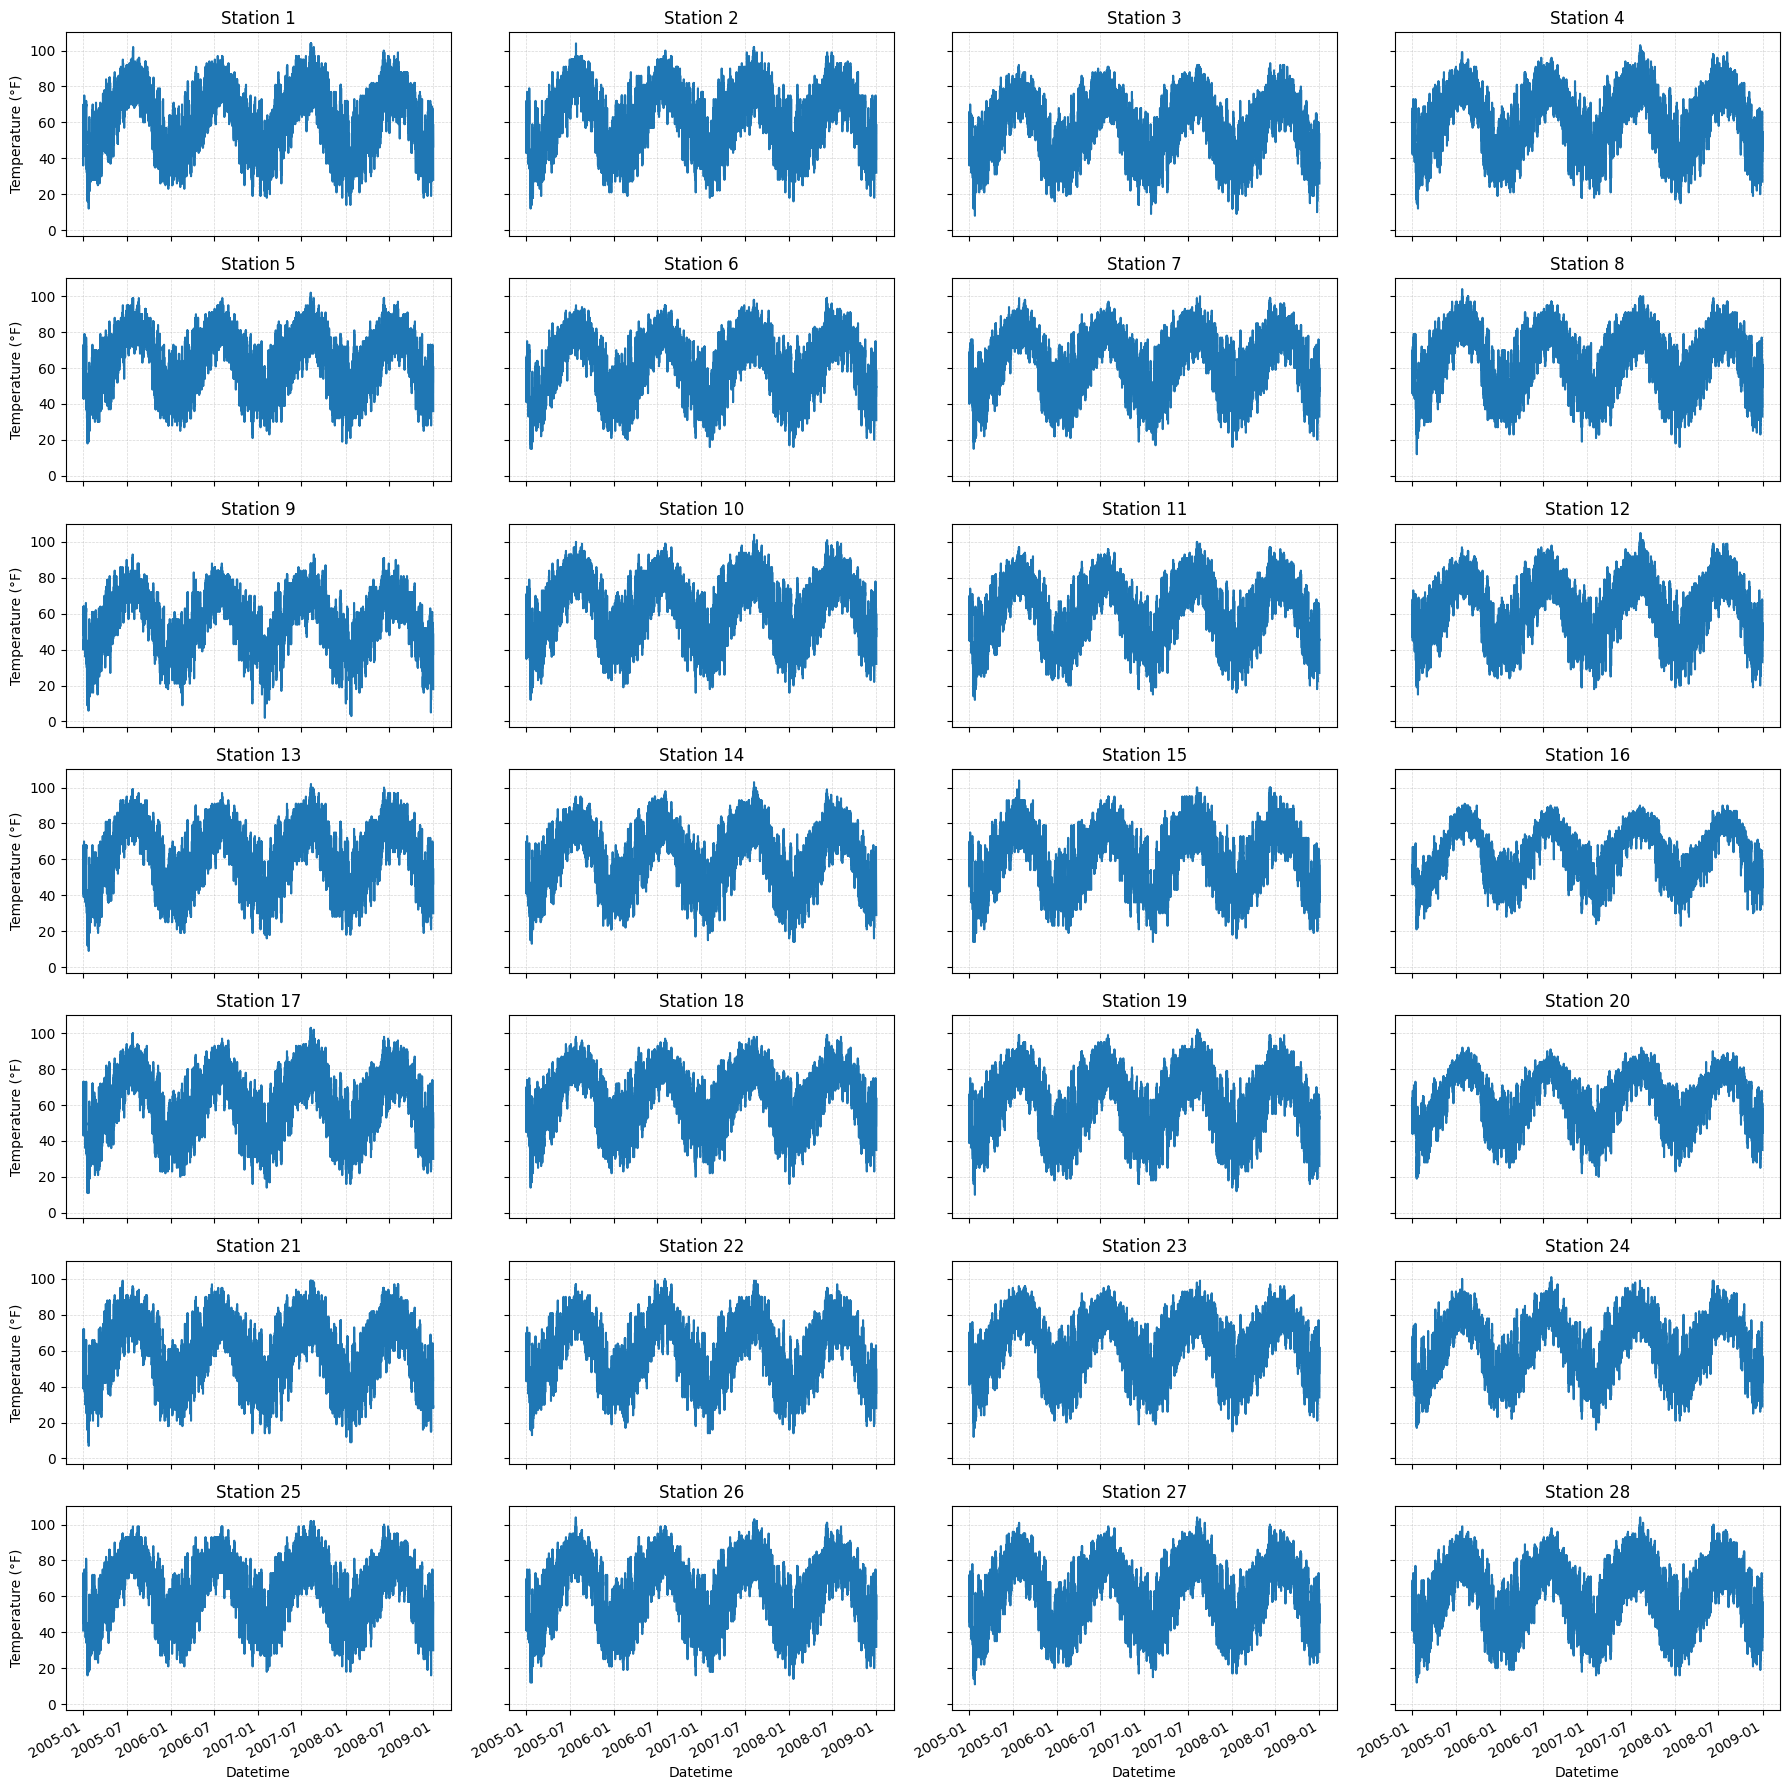

In [21]:
fig, ax = plt.subplots(7,4, figsize=(18, 18), sharex=True, sharey=True)

for i, station in enumerate(weather_pivot.columns):
    sns.lineplot(data=weather_pivot, x=weather_pivot.index, y=station, ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(station)
    ax[i // 4, i % 4].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
    ax[i // 4, i % 4].set_ylabel("Temperature (°F)")

plt.gcf().autofmt_xdate()
plt.tight_layout()

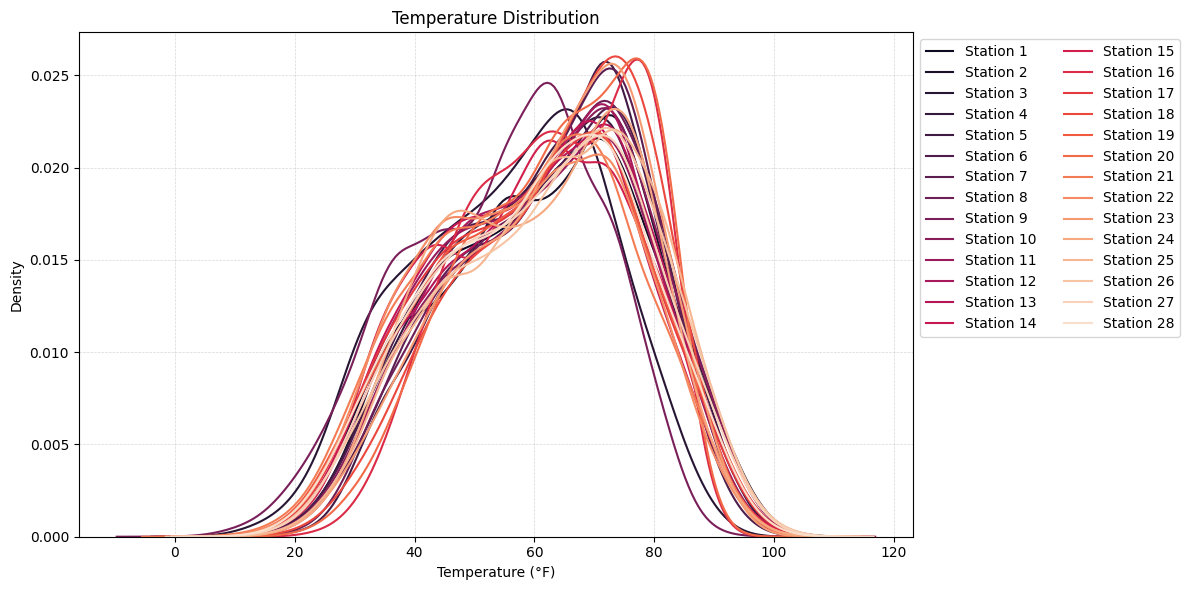

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

palette = sns.color_palette("rocket", 28)

for i, station in enumerate(weather_pivot.columns):
    sns.kdeplot(data=weather_pivot, x=station, ax=ax, label=station, color=palette[i], bw_adjust=2)

ax.set_title("Temperature Distribution")
ax.set_xlabel("Temperature (°F)")
ax.legend(ncols=2, bbox_to_anchor=(1, 1))
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.tight_layout()

In [23]:
for i, station in enumerate(weather_pivot.columns):
    print(f"Station {station}: Nans: {weather_pivot[station].isna().sum()}")

Station Station 1: Nans: 0
Station Station 2: Nans: 0
Station Station 3: Nans: 0
Station Station 4: Nans: 0
Station Station 5: Nans: 0
Station Station 6: Nans: 0
Station Station 7: Nans: 0
Station Station 8: Nans: 0
Station Station 9: Nans: 0
Station Station 10: Nans: 0
Station Station 11: Nans: 0
Station Station 12: Nans: 0
Station Station 13: Nans: 0
Station Station 14: Nans: 0
Station Station 15: Nans: 0
Station Station 16: Nans: 0
Station Station 17: Nans: 0
Station Station 18: Nans: 0
Station Station 19: Nans: 0
Station Station 20: Nans: 0
Station Station 21: Nans: 0
Station Station 22: Nans: 0
Station Station 23: Nans: 0
Station Station 24: Nans: 0
Station Station 25: Nans: 0
Station Station 26: Nans: 0
Station Station 27: Nans: 0
Station Station 28: Nans: 0


In [24]:
weather_full_range = pd.date_range(
    start=weather.index.min(), end=weather.index.max(), freq="h"
)
weather_missing_datetimes = weather_full_range.difference(weather_pivot.index)
print(f"Missing datetimes: {weather_missing_datetimes}")
# Daylight Saving Time (DST) transition

Missing datetimes: DatetimeIndex(['2005-04-03 01:00:00', '2006-04-02 01:00:00',
               '2007-03-11 01:00:00', '2008-03-09 01:00:00'],
              dtype='datetime64[ns]', freq=None)


In [25]:
weather_duplicated_datetimes = weather_pivot.index[weather_pivot.index.duplicated()]
print(f"Duplicated datetimes: {weather_duplicated_datetimes}")
# Daylight Saving Time (DST) transition (averaged)

Duplicated datetimes: DatetimeIndex([], dtype='datetime64[ns]', name='Datetime', freq=None)


In [26]:
weather_pivot.describe().T

,count,mean,std,min,25%,50%,75%,max
Station 1,35060.0,61.215088,16.995040,12.0,48.0,63.0,74.0,104.0
Station 2,35060.0,61.860011,16.768754,12.0,48.0,63.0,75.0,104.0
Station 3,35060.0,55.671535,16.084260,8.0,43.0,57.0,68.0,93.0
Station 4,35060.0,61.197362,16.249025,12.0,49.0,63.0,74.0,103.0
Station 5,35060.0,63.216244,15.344094,18.0,52.0,64.0,75.0,102.0
Station 6,35060.0,60.912607,15.959678,15.0,48.0,63.0,74.0,99.0
Station 7,35060.0,62.354364,15.725955,15.0,50.0,65.0,75.0,100.0
Station 8,35060.0,63.244467,15.953834,12.0,52.0,64.0,75.0,104.0
Station 9,35060.0,54.428280,15.795368,2.0,43.0,57.0,66.0,93.0
Station 10,35060.0,62.349073,16.467500,12.0,50.0,64.0,75.0,104.0


### Add time features

In [27]:
weather_pivot["Day"] = weather_pivot.index.day.astype("int")
weather_pivot["Dayofweek"] = weather_pivot.index.dayofweek.astype("int")
weather_pivot["Dayofyear"] = weather_pivot.index.dayofyear.astype("int")
weather_pivot["Week"] = weather_pivot.index.isocalendar().week.astype("int")
weather_pivot["Month"] = weather_pivot.index.month.astype("int")
weather_pivot["Quarter"] = weather_pivot.index.quarter.astype("int")
weather_pivot["Year"] = weather_pivot.index.year.astype("int")
us_holidays = holidays.US()
weather_pivot["Holiday"] = [
    1 if date in us_holidays else 0 for date in weather_pivot.index.date
]

# (TODO) Add cyclic features

In [28]:
# Add lagged features
for station in [
    f"Station {i+1}" for i in range(28)
]:  
    for i in range(1, 6):
        weather_pivot[f"{station}_prev_hour_{i}"] = weather_pivot[station].shift(i)
        weather_pivot[f"{station}_next_hour_{i}"] = weather_pivot[station].shift(-i)


/var/folders/m5/_jylkv1537d978cwv_lk0g0r0000gp/T/ipykernel_23722/98243561.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weather_pivot[f"{station}_next_hour_{i}"] = weather_pivot[station].shift(-i)
/var/folders/m5/_jylkv1537d978cwv_lk0g0r0000gp/T/ipykernel_23722/98243561.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weather_pivot[f"{station}_prev_hour_{i}"] = weather_pivot[station].shift(i)
/var/folders/m5/_jylkv1537d978cwv_lk0g0r0000gp/T/ipykernel_23722/98243561.py:7: PerformanceWarning: DataFrame is highly fragmente

## Preparation Data for Training

In [29]:
merged_data = pd.merge(weather_pivot, load, left_index=True, right_index=True, how="inner")

In [30]:
training_data = merged_data.drop(columns=["Date", "Load"])

In [31]:
target = "is_peak"
training_columns = training_data.columns.drop(target)

In [32]:
training_columns

Index(['Station 1', 'Station 2', 'Station 3', 'Station 4', 'Station 5',
       'Station 6', 'Station 7', 'Station 8', 'Station 9', 'Station 10',
       ...
       'Station 28_next_hour_1', 'Station 28_prev_hour_2',
       'Station 28_next_hour_2', 'Station 28_prev_hour_3',
       'Station 28_next_hour_3', 'Station 28_prev_hour_4',
       'Station 28_next_hour_4', 'Station 28_prev_hour_5',
       'Station 28_next_hour_5', 'Hour'],
      dtype='object', length=317)

In [33]:
folds = expanding_window_cross_validation(training_data, initial_train_years=0, years_in_data=3, first_year=2005)

In [42]:
weather_pivot.fillna(method='ffill').fillna(method='bfill')

/var/folders/m5/_jylkv1537d978cwv_lk0g0r0000gp/T/ipykernel_23722/3649185669.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_pivot.fillna(method='ffill').fillna(method='bfill')


,Station 1,Station 2,Station 3,Station 4,Station 5,Station 6,Station 7,Station 8,Station 9,Station 10,...,Station 28_prev_hour_1,Station 28_next_hour_1,Station 28_prev_hour_2,Station 28_next_hour_2,Station 28_prev_hour_3,Station 28_next_hour_3,Station 28_prev_hour_4,Station 28_next_hour_4,Station 28_prev_hour_5,Station 28_next_hour_5
Datetime,,,,,,,,,,,,,,,,,,,,,
2005-01-01 00:00:00,43.0,46.0,40.0,47.0,48.0,46.0,44.0,52.0,45.0,42.0,...,45.0,45.0,45.0,43.0,45.0,44.0,45.0,44.0,45.0,42.0
2005-01-01 01:00:00,41.0,46.0,38.0,46.0,48.0,45.0,51.0,50.0,42.0,41.0,...,45.0,43.0,45.0,44.0,45.0,44.0,45.0,42.0,45.0,42.0
2005-01-01 02:00:00,40.0,46.0,37.0,45.0,45.0,45.0,49.0,48.0,43.0,40.0,...,45.0,44.0,45.0,44.0,45.0,42.0,45.0,42.0,45.0,41.0
2005-01-01 03:00:00,39.0,46.0,37.0,47.0,48.0,48.0,45.0,50.0,42.0,39.0,...,43.0,44.0,45.0,42.0,45.0,42.0,45.0,41.0,45.0,48.0
2005-01-01 04:00:00,38.0,46.0,37.0,44.0,48.0,49.0,43.0,50.0,42.0,38.0,...,44.0,42.0,43.0,42.0,45.0,41.0,45.0,48.0,45.0,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-31 19:00:00,37.0,37.0,31.0,36.0,43.0,37.0,40.0,42.0,21.0,39.0,...,38.0,34.0,40.0,33.0,42.0,31.0,46.0,30.0,48.0,30.0
2008-12-31 20:00:00,34.0,36.0,29.0,34.0,41.0,36.0,38.0,40.0,19.0,37.0,...,36.0,33.0,38.0,31.0,40.0,30.0,42.0,30.0,46.0,30.0
2008-12-31 21:00:00,34.0,36.0,28.0,33.0,39.0,35.0,36.0,38.0,19.0,36.0,...,34.0,31.0,36.0,30.0,38.0,30.0,40.0,30.0,42.0,30.0


In [34]:
for i, (train, test) in enumerate(folds):
    print(f"Fold {i+1}:")
    print(f"Training set: {train.index.min()} to {train.index.max()}")
    print(f"Testing set: {test.index.min()} to {test.index.max()}\n")

Fold 1:
Training set: 2005-01-01 00:00:00 to 2005-12-31 23:00:00
Testing set: 2006-01-01 00:00:00 to 2006-12-31 23:00:00

Fold 2:
Training set: 2005-01-01 00:00:00 to 2006-12-31 23:00:00
Testing set: 2007-01-01 00:00:00 to 2007-12-31 23:00:00

Fold 3:
Training set: 2005-01-01 00:00:00 to 2007-12-31 23:00:00
Testing set: NaT to NaT



In [35]:
for i, (train, test) in enumerate(folds[:-1]):
    X_train, y_train = train[training_columns], train[target]
    X_test, y_test = test[training_columns], test[target]

    # Initialize the LGBMClassifier
    lgbm_classifier = lgb.LGBMClassifier()

    # Train the model
    lgbm_classifier.fit(X_train, y_train)

    # Get probabilistic predictions (probabilities for each class)
    probabilities = lgbm_classifier.predict_proba(X_test)

    test["Date"] = test.index.date
    test["class_probability"] = probabilities[:, 1]
    test["rounded_probability"] = (test["class_probability"] * 24).round() / 24
    test["normalized_probability"] = test.groupby("Date")[
        "class_probability"
    ].transform(lambda x: x / x.sum())

    test["predicted_is_peak"] = (
        test.groupby("Date")["normalized_probability"].transform(lambda x: x == x.max()).astype(int)
    )
    
    
    print(f"Fold {i+1}: Score {score(test["normalized_probability"], y_test)}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 372, number of negative: 8388
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25117
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 316
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.042466 -> initscore=-3.115664
[LightGBM] [Info] Start training from score -3.115664
Fold 1: Score 254.41443860272557
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 746, number of negative: 16774
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

In [36]:
test_clean = test.drop(columns=training_columns)

In [ ]:
test_clean.groupby("Date")["normalized_probability"].sum()

In [ ]:
score(test_clean["normalized_probability"], y_test)


In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))

central_date = pd.to_datetime("2007-02-01")
delta = pd.Timedelta("4D")

sns.scatterplot(
    data=test_clean[central_date - delta : central_date + delta],
    x=test_clean[central_date - delta : central_date + delta].index,
    y="is_peak",
    color="black",
    ax=ax,
)
sns.scatterplot(
    data=test_clean[central_date - delta : central_date + delta],
    x=test_clean[central_date - delta : central_date + delta].index,
    y="predicted_is_peak",
    color="red",
    marker="x",
    linewidth=1.5,
    alpha=0.8,
    ax=ax,
)
sns.scatterplot(
    data=test_clean[central_date - delta : central_date + delta],
    x=test_clean[central_date - delta : central_date + delta].index,
    y="Probability",
    color="blue",
    marker="v",
    linewidth=1.5,
    alpha=0.8,
    ax=ax,
)

ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
